In [27]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv1D, MaxPool1D, MaxPool2D, Softmax, BatchNormalization
from tensorflow.keras import Model
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from umap import UMAP
import umap.plot
from umap.parametric_umap import ParametricUMAP
import flowkit as fk
import FlowCal as fc
import bokeh
from bokeh.plotting import show
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import numpy as np
import skbio
import sys
import os
import glob
import joypy
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV

bokeh.io.output_notebook()
%matplotlib inline

_ = plt.ioff()

main_dir = "/home/n10853499/01-projects/00-allison_microscope/"

Loading BokehJS ...

In [81]:
import pandas as pd
from Bio import SeqIO
import os

def find_circular(checkm_output, checkm1=True):
    if checkm1:
        bin_column = "Bin Id"
    else:
        bin_column = "Name"

    circular_contigs = []
    circular_bps = []
    circular_fractions = []

    assembly_info = pd.read_csv("/mnt/hpccs01/scratch/microbiome/n10853499/03-aviary_testing/00-zymo_hybrid_assembly_benchmark/aviary/SRR10084338/data/flye/assembly_info.txt", sep="\t")

    for bin_name in checkm_output[bin_column]:

        fasta_path = f"/mnt/hpccs01/scratch/microbiome/n10853499/03-aviary_testing/00-zymo_hybrid_assembly_benchmark/aviary/SRR10084338/bins/final_bins/{bin_name}.fna"
        circular = 0
        circular_bases = 0
        total_size = 0
        for sequence in SeqIO.parse(open(fasta_path), "fasta"):
            total_size += len(sequence.seq)
            seq_name = sequence.id.strip("_pilon")

            if seq_name not in assembly_info["#seq_name"].values:
                continue

            found = assembly_info[assembly_info["#seq_name"] == seq_name]

            if found["circ."].values[0] == "N":
                continue
            circular += 1
            circular_bases += found["length"].values[0]


        circular_bps.append(circular_bases)
        circular_contigs.append(circular)
        circular_fractions.append(circular_bases / total_size)
    
    print(circular_contigs)
    checkm_output["Circular contigs"], checkm_output["Circular bp"], checkm_output["Circular fraction"] = [circular_contigs, circular_bps, circular_fractions]
    return checkm_output

coverage_file = pd.read_csv("/mnt/hpccs01/scratch/microbiome/n10853499/03-aviary_testing/00-zymo_hybrid_assembly_benchmark/aviary/SRR10084338/data/coverm_abundances.tsv", sep='\t')

# checkm file for all bins
checkm_output = pd.read_csv("/mnt/hpccs01/scratch/microbiome/n10853499/03-aviary_testing/00-zymo_hybrid_assembly_benchmark/aviary/SRR10084338/bins/checkm.out", sep='\t', comment="[")
# print(checkm_output)

is_checkm1 = "Bin Id" in checkm_output.columns
coverage_file.rename({"Genome" : checkm_output.columns[0]}, inplace=True, axis=1)


if os.path.isfile("/mnt/hpccs01/scratch/microbiome/n10853499/03-aviary_testing/00-zymo_hybrid_assembly_benchmark/aviary/SRR10084338/data/flye/assembly_info.txt"):
    checkm_output = find_circular(checkm_output, is_checkm1)

# print(checkm_output)
# print(coverage_file)
merged_out = pd.merge(checkm_output, coverage_file, on=[checkm_output.columns[0]])
print(merged_out)

[0, 1, 0, 0, 1, 0, 0]
             Bin Id                Marker lineage  # genomes  # markers  \
0  binned_contigs.1          k__Bacteria (UID203)       5449        104   
1  binned_contigs.2  o__Pseudomonadales (UID4488)        185        813   
2  binned_contigs.3          g__Bacillus (UID865)         36       1200   
3  binned_contigs.4                   root (UID1)       5656         56   
4  binned_contigs.5             k__Archaea (UID2)        207        149   
5  binned_contigs.6          k__Bacteria (UID203)       5449        104   
6  binned_contigs.7           c__Bacilli (UID354)        515        329   

   # marker sets  Completeness  Contamination  Strain heterogeneity  \
0             58         43.10           0.00                   0.0   
1            308         99.62           0.61                   0.0   
2            269         41.98           0.00                   0.0   
3             24          0.00           0.00                   0.0   
4            107      

In [79]:
assembly_info = pd.read_csv("/mnt/hpccs01/scratch/microbiome/n10853499/03-aviary_testing/00-zymo_hybrid_assembly_benchmark/aviary/SRR10084338/data/flye/assembly_info.txt", sep="\t")
"contig_1" in assembly_info["#seq_name"].values
# checkm_output.columns[0]

True

In [308]:
# glob.glob(main_dir + "reference_cultures/Pro_and_syn/*/*cus*fcs")
from sklearn.preprocessing import RobustScaler, MinMaxScaler
# df[df["FSC-A"] < 100000]

def reference_cultures(files = [main_dir + 'reference_cultures/Pro_and_syn/fixed/PFA_40_Prochlorococcus_MIT9312.fcs', main_dir + "reference_cultures/Pro_and_syn/fixed/PFA_15_Synechococcus_PH4_0_D8.fcs"]):
#     logicle_xform = fk.transforms.AsinhTransform("asinh", param_t=262144, param_m=4.0, param_a=0.0)    
    logicle_xform = fk.transforms.LogicleTransform("logicle", param_t=262144, param_w=0.5, param_m=4.5, param_a=0)
    # gathering the training data
    main_df = []
    labels = []
    
    strains = {}
    strain_index = 0
    
    species_map = {}
    species_index = 0
    
    exps = {0: 0, 5: 1, 15: 2, 40: 3}
    exp_index = 0
    
    for file in files:
        name = file.split("/")[-1].strip(".fcs")
        light_exp = 0
        strain = ""
        species = ""
        fixed = False
        dilution = 0

         # skip non-slow speeds
        if any(speed in name for speed in ["high", "med"]):
            continue

        # get dilution level
        if "diluted" in name:
            if "diluted heaps" in name or "diluted heap" in name:
                dilution = 2
                name = name.strip(" diluted heaps")
                name = name.strip(" diluted heap")
            else:
                dilution = 1
                name = name.strip("_diluted")
                name = name.strip(" diluted")

        name = name.split("_")
        print(name)
        # get light exposure and strain name
        if "LightExp" in name or "PFA" in name:
            if "PFA" in name:
                fixed = True

            light_exp = int(name[1])
            # rename badly named files
            if name[2] == "Prochloroccocus" or name[2] == "Prochloroccocus":
                name[2] = "Prochlorococcus"
            elif name[2] == "Synecoccocus" or name[2] == "Synechoccocus":
                name[2] = "Synechococcus"
            strain = "_".join(name[2:])
            species = name[2]
        else:
            # rename badly named files
            if name[0] == "Prochloroccocus" or name[0] == "Prochloroccocus":
                name[0] = "Prochlorococcus"
            elif name[0] == "Synecoccocus" or name[0] == "Synechoccocus":
                name[0] = "Synechococcus"

            name[1] = "_".join(name[1].split(" ")).upper()
            strain = "_".join(name)
            species = name[0]
        
        print(species, strain)
        if strain in ["Prochlorococcus_CC9605", "Synechococcus_BBP2", "Ostreococcus_TAURI_RCC4221", "Synechococcus_CC9311"] or (
            strain in ["Prochlorococcus_NATL2A"] and light_exp == 40 or strain in ["Prochlorococcus_SS120"] and light_exp in [5, 15]
        ): # potentially contaminated?
            continue
        
        fk_file = fk.Sample(file, subsample=25000)
#         fk_file.filter_negative_scatter()
        fk_file.pns_labels = fk_file.pnn_labels
        fk_file.apply_transform(logicle_xform)
        s_g1 = fc.gate.density2d(fk_file.as_dataframe(source="xform")[['FSC-A', 'SSC-A']].values, gate_fraction=0.5, full_output=True)
#         gated = 
        df = fk_file.as_dataframe(source='xform', subsample=False)
        df.columns = df.columns.get_level_values(0)
        to_select = ["-A" in col for col in df.columns]

        df = df.loc[:, to_select]
#         print(s_g1.mask)
        df = df.loc[np.array(s_g1.mask), :]
        
#         df = mean_scatter_filter(df)
        # convert strain to int index
        try:
            df['strain'] = strains[strain]
        except KeyError:
            strains[strain] = strain_index
            strain_index += 1
            df['strain'] = strains[strain]
        
        
        try:
            df['species'] = species_map[species]
        except KeyError:
            species_map[species] = species_index
            species_index += 1
            df['species'] = species_map[species]
        
        df['fixed'] = fixed
        df['dilution'] = dilution
        df['strain_name'] = strain
        
        try:
            df['light_exp'] = exps[light_exp]
        except KeyError:
            exps[light_exp] = exp_index
            exp_index += 1
            df['light_exp'] = exps[light_exp]
        
        labels.append(df.loc[:, ["-" not in col for col in df.columns]])
        main_df.append(df.loc[:, ["-" in col for col in df.columns]])

    main_df = pd.concat(main_df)
#     min_df = main_df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']].min()
    min_df = main_df[['FSC-A', 'SSC-A', 'SSC-B-A']].min()
#     main_df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']] = main_df[['FSC-A', 'SSC-A', 'SSC-B-A', 'FSC-H', 'SSC-H', 'SSC-B-H']] / min_df
    main_df[['FSC-A', 'SSC-A', 'SSC-B-A']] = main_df[['FSC-A', 'SSC-A', 'SSC-B-A']] / min_df
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(main_df)
#     main_df[['FSC-A', 'SSC-A', 'SSC-B-A']] = scaler.fit_transform(main_df[['FSC-A', 'SSC-A', 'SSC-B-A']])
    
    labels = pd.concat(labels)
    return scaled_df, labels, min_df, main_df

def mean_scatter_filter(df, sd_tolerance=1.5):
    
#     print(df[['FSC-A', 'SSC-A', 'SSC-B-A']].mean(), df[['FSC-A', 'SSC-A', 'SSC-B-A']].std())
    greater_than_min = (df[['FSC-A', 'SSC-A', 'SSC-B-A']] > (df[['FSC-A', 'SSC-A', 'SSC-B-A']].mean() - df[['FSC-A', 'SSC-A', 'SSC-B-A']].std() / 2)).values.all(axis=1)
    less_than_max = (df[['FSC-A', 'SSC-A', 'SSC-B-A']] < (df[['FSC-A', 'SSC-A', 'SSC-B-A']].mean() + df[['FSC-A', 'SSC-A', 'SSC-B-A']].std() / 2)).values.all(axis=1)
    df = df[np.array([greater_than_min, less_than_max]).all(axis=0)]
    return df
    
# print(glob.glob(main_dir + "reference_cultures/Pro_and_syn/fixed/final/*cus*fcs") + glob.glob(main_dir + "reference_cultures/Pro_and_syn/fresh/*cus*fcs"))

In [309]:
# ref_df = reference_cultures()
df, df_labels, min_df, unscaled_df = reference_cultures(glob.glob(main_dir + "reference_cultures/Pro_and_syn/fixed/final/*cus*fcs") + glob.glob(main_dir + "reference_cultures/Pro_and_syn/fresh/*cus*fcs"))


['PFA', '15', 'Prochlorococcus', 'CC9605']
Prochlorococcus Prochlorococcus_CC9605
['PFA', '15', 'Prochlorococcus', 'MIT9312']
Prochlorococcus Prochlorococcus_MIT9312
['PFA', '15', 'Prochlorococcus', 'NATL2A']
Prochlorococcus Prochlorococcus_NATL2A
['PFA', '15', 'Prochlorococcus', 'SS120']
Prochlorococcus Prochlorococcus_SS120
['PFA', '15', 'Synechococcus', 'BBP1']
Synechococcus Synechococcus_BBP1
['PFA', '15', 'Synechococcus', 'BBP2']
Synechococcus Synechococcus_BBP2
['PFA', '15', 'Synechococcus', 'IN16', '44']
Synechococcus Synechococcus_IN16_44
['PFA', '15', 'Synechococcus', 'MARCIA', 'R1']
Synechococcus Synechococcus_MARCIA_R1
['PFA', '15', 'Synechococcus', 'MITS9220']
Synechococcus Synechococcus_MITS9220
['PFA', '15', 'Synechococcus', 'PH4', '0', 'D8']
Synechococcus Synechococcus_PH4_0_D8
['PFA', '15', 'Synechococcus', 'RS9916']
Synechococcus Synechococcus_RS9916
['PFA', '15', 'Synechococcus', 'WH8109']
Synechococcus Synechococcus_WH8109
['PFA', '40', 'Prochlorococcus', 'MIT9312']


In [242]:
df_labels

pnn,strain,species,fixed,dilution,strain_name,light_exp
5,0,0,True,0,Prochlorococcus_MIT9312,2
6,0,0,True,0,Prochlorococcus_MIT9312,2
7,0,0,True,0,Prochlorococcus_MIT9312,2
17,0,0,True,0,Prochlorococcus_MIT9312,2
20,0,0,True,0,Prochlorococcus_MIT9312,2
...,...,...,...,...,...,...
11512,15,1,False,0,Synechococcus_WH8102,0
11513,15,1,False,0,Synechococcus_WH8102,0
11516,15,1,False,0,Synechococcus_WH8102,0
11521,15,1,False,0,Synechococcus_WH8102,0


In [117]:
# pd.concat([unscaled_df.reset_index(), df_labels['strain'].reset_index()], axis=1).groupby('strain').mean().transpose()
pd.concat([unscaled_df.reset_index(), df_labels['strain_name'].reset_index()], axis=1).drop("index", axis=1)

,UV1-A,UV2-A,UV3-A,UV4-A,UV5-A,UV6-A,UV7-A,UV8-A,UV9-A,UV10-A,...,YG10-A,R1-A,R2-A,R3-A,R4-A,R5-A,R6-A,R7-A,R8-A,strain_name
0,-0.161742,-0.169076,-0.293750,0.056402,0.216531,0.119061,0.311687,-0.020970,0.297205,0.208062,...,-0.172811,-0.316391,0.118670,-0.088750,-0.026459,0.007725,0.254720,-0.033019,-0.252216,Prochlorococcus_SS120
1,0.068659,0.198299,0.165932,0.265917,-0.250719,0.287375,0.368907,0.247177,0.269019,-0.088337,...,0.195530,-0.290037,0.234730,0.333074,-0.156454,0.145573,0.185324,0.232765,-0.327153,Prochlorococcus_SS120
2,0.050958,-0.138511,0.236083,0.306843,-0.240850,0.024536,0.234376,-0.118919,0.232322,-0.272486,...,-0.222643,-0.324442,0.314811,0.057751,-0.190786,0.290027,0.231140,-0.241758,-0.306280,Prochlorococcus_SS120
3,-0.321734,-0.277820,-0.200088,0.380857,0.237609,-0.122775,0.137990,-0.096679,0.334771,0.143245,...,-0.262199,-0.250506,0.310048,0.217510,-0.018444,0.103863,-0.217298,0.205912,0.222791,Prochlorococcus_SS120
4,0.019618,-0.126576,0.232373,-0.153284,0.262523,0.216131,0.234799,0.194935,-0.264450,-0.253292,...,0.051376,0.420029,0.555466,0.548581,0.439036,0.468528,0.399608,0.388621,0.301220,Prochlorococcus_SS120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2281406,0.230941,-0.250801,0.325133,0.177340,-0.229387,-0.212372,0.312628,0.322336,0.550130,0.417338,...,0.474767,0.564911,0.599752,0.574740,0.534019,0.500835,0.480527,0.438776,0.414433,Synechococcus_PH4_0_D8
2281407,0.191712,-0.231741,0.238310,-0.189057,-0.087235,-0.162051,0.144353,0.386647,0.551046,0.470174,...,0.512715,0.578902,0.620588,0.599517,0.542638,0.539834,0.461885,0.499437,0.385971,Synechococcus_PH4_0_D8
2281408,-0.318555,0.000000,-0.077067,-0.155348,0.235830,0.212068,0.145800,0.415986,0.580273,0.476501,...,0.528315,0.580009,0.628084,0.604606,0.556893,0.533511,0.482690,0.416028,0.286911,Synechococcus_PH4_0_D8
2281409,-0.235279,-0.348758,0.084601,-0.282773,0.153196,0.205432,0.289006,0.417089,0.583471,0.478738,...,0.527091,0.592156,0.625118,0.611908,0.553021,0.535323,0.475925,0.484401,0.269629,Synechococcus_PH4_0_D8


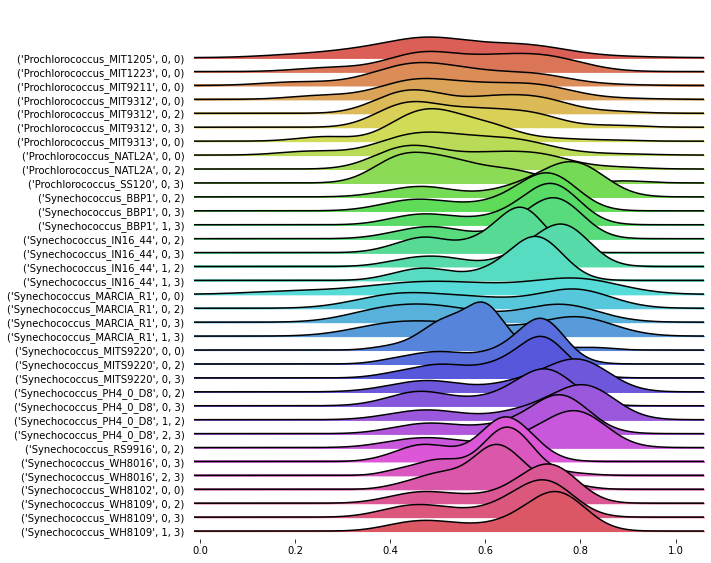

In [310]:
# df_labels['strain'].unique().shape[0]
# # np.isnan(df).any()
# df_labels['strain'].unique()
# pd.concat([unscaled_df, df_labels['strain']], axis=1).groupby('strain').mean().transpose()
# pd.DataFrame(df)
# pd.concat([pd.DataFrame(df), df_labels['strain'].reset_index()], axis=1)
# pd.concat([pd.DataFrame(df), df_labels[['strain_name', 'dilution', 'light_exp']].reset_index()], axis=1).drop("index", axis=1).groupby(['strain_name', 'dilution', 'light_exp']).mean().transpose()
# import seaborn as sns
joy_df = pd.concat([pd.DataFrame(df), df_labels[['strain_name', 'dilution', 'light_exp']].reset_index()], axis=1).drop("index", axis=1).groupby(['strain_name', 'dilution', 'light_exp']).mean().transpose()
joypy.joyplot(joy_df, figsize=(10, 8), labels=joy_df.columns.get_level_values(0), color=sns.color_palette("hls", len(joy_df.columns.get_level_values(0))))
plt.show()
# "Synechococcus_CC9311"

In [311]:
joy_df.corr()

strain_name                                Prochlorococcus_MIT1205  \
dilution                                                         0   
light_exp                                                        0   
strain_name             dilution light_exp                           
Prochlorococcus_MIT1205 0        0                        1.000000   
Prochlorococcus_MIT1223 0        0                        0.938025   
Prochlorococcus_MIT9211 0        0                        0.947510   
Prochlorococcus_MIT9312 0        0                        0.979673   
                                 2                        0.911266   
                                 3                        0.919639   
Prochlorococcus_MIT9313 0        0                        0.958846   
Prochlorococcus_NATL2A  0        0                        0.983914   
                                 2                        0.919150   
Prochlorococcus_SS120   0        3                        0.906314   
Synechococcus_BBP1      0        2                        0.209411   
                                 3                        0.221051   
                        1        3                        0.339500   
Synechococcus_IN16_44   0        2                        0.138644   
                                 3                        0.236807   
                        1        2                        0.216199   
                                 3                        0.342785   
Synechococcus_MARCIA_R1 0        0                        0.807476   
                                 2                        0.744473   
                                 3                        0.753897   
                        1        3                        0.742652   
Synechococcus_MITS9220  0        0                        0.540732   
                                 2                        0.181164   
                                 3                        0.142855   
Synechococcus_PH4_0_D8  0        2                        0.114094   
                                 3                        0.106046   
                        1        2                        0.253313   
                        2        3                        0.339553   
Synechococcus_RS9916    0        2                        0.122810   
Synechococcus_WH8016    0        3                        0.327191   
                        2        3                        0.547724   
Synechococcus_WH8102    0        0                        0.568686   
Synechococcus_WH8109    0        2                        0.305161   
                                 3                        0.210424   
                        1        3                        0.338993   

strain_name                                Prochlorococcus_MIT1223  \
dilution                                                         0   
light_exp                                                        0   
strain_name             dilution light_exp                           
Prochlorococcus_MIT1205 0        0                        0.938025   
Prochlorococcus_MIT1223 0        0                        1.000000   
Prochlorococcus_MIT9211 0        0                        0.896332   
Prochlorococcus_MIT9312 0        0                        0.973513   
                                 2                        0.914895   
                                 3                        0.896481   
Prochlorococcus_MIT9313 0        0                        0.921662   
Prochlorococcus_NATL2A  0        0                        0.959536   
                                 2                        0.911140   
Prochlorococcus_SS120   0        3                        0.833774   
Synechococcus_BBP1      0        2                        0.382123   
                                 3                        0.347123   
                        1        3                        0.492867   
Synechococcus_IN16_44   0        2                        0.280912   
         

In [65]:
df_bac = pd.read_csv(glob.glob("/mnt/hpccs01/scratch/microbiome/n10853499/03-aviary_testing/00-zymo_hybrid_assembly_benchmark/aviary/SRR10084338" + "/taxonomy/gtdbtk.ar*.summary.tsv")[0], sep="\t")
# print(df_bac)
df_bac['user_genome'] = df_bac['user_genome'].apply(lambda bin: os.path.abspath("/mnt/hpccs01/scratch/microbiome/n10853499/03-aviary_testing/00-zymo_hybrid_assembly_benchmark/aviary/SRR10084338") + "/bins/final_bins/" + str(bin))
print(df_bac)

IndexError: list index out of range

In [255]:
df_labels

pnn,strain,species,fixed,dilution,strain_name,light_exp
5,0,0,True,0,Prochlorococcus_MIT9312,2
6,0,0,True,0,Prochlorococcus_MIT9312,2
7,0,0,True,0,Prochlorococcus_MIT9312,2
17,0,0,True,0,Prochlorococcus_MIT9312,2
20,0,0,True,0,Prochlorococcus_MIT9312,2
...,...,...,...,...,...,...
11512,15,1,False,0,Synechococcus_WH8102,0
11513,15,1,False,0,Synechococcus_WH8102,0
11516,15,1,False,0,Synechococcus_WH8102,0
11521,15,1,False,0,Synechococcus_WH8102,0


In [324]:
x_train, x_test, y_train, y_test = train_test_split(df, df_labels.iloc[:, 0])

print(x_train.shape)

(6926599, 67)


In [289]:
x_train

pnn,UV1-A,UV2-A,UV3-A,UV4-A,UV5-A,UV6-A,UV7-A,UV8-A,UV9-A,UV10-A,...,YG9-A,YG10-A,R1-A,R2-A,R3-A,R4-A,R5-A,R6-A,R7-A,R8-A
81296,-0.088017,-0.061720,-0.032482,0.433044,0.378393,0.200230,-0.143195,0.020508,0.572034,0.522822,...,0.659168,0.582197,0.668594,0.712457,0.687985,0.643008,0.633309,0.592557,0.547444,0.475961
448753,0.123641,0.060020,0.262732,0.313824,0.227364,-0.165809,0.036820,0.515014,0.655906,0.564757,...,0.686374,0.615085,0.690841,0.712639,0.695128,0.653530,0.632276,0.576100,0.585743,0.524416
217424,-0.202573,0.338162,-0.022423,0.225564,0.440003,0.006879,0.350482,0.275394,0.275358,0.037461,...,-0.034817,0.045268,0.270910,0.332390,0.086965,-0.089236,-0.127881,0.180373,0.269374,0.071071
485526,0.379298,-0.137525,0.179431,-0.061446,-0.054244,0.425427,0.217423,-0.063424,0.073142,0.370706,...,0.607481,0.544485,0.791252,0.793830,0.775618,0.746701,0.716965,0.656403,0.641836,0.557169
240006,-0.017379,-0.159444,0.163899,0.351892,0.371884,-0.046407,-0.071176,0.390553,0.210737,0.139713,...,0.404941,0.252616,0.172125,0.229196,0.354780,0.045069,0.019755,0.389787,-0.169201,0.126593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76070,0.151302,-0.194496,0.254992,-0.103117,0.319508,-0.025347,0.274805,0.138280,0.315169,0.341755,...,0.600619,0.548869,0.750600,0.763657,0.743396,0.717214,0.690485,0.631237,0.623705,0.547472
410539,-0.127030,-0.144714,0.170553,0.295068,-0.068301,-0.028803,-0.124123,0.070736,0.084929,0.343762,...,0.578898,0.545002,0.766134,0.767908,0.750100,0.718897,0.681776,0.621007,0.610157,0.552120
149220,0.202842,0.066347,0.082374,0.204214,-0.093768,0.341416,0.436320,0.422432,0.204090,0.244787,...,0.386612,0.061475,0.182602,0.401479,0.427713,0.254360,0.158292,0.350797,0.424167,0.254533
403597,0.065223,-0.058397,-0.112167,0.283149,0.151497,0.268042,-0.133129,0.512848,0.628744,0.546959,...,0.653526,0.566859,0.604578,0.655764,0.654279,0.578798,0.566646,0.538900,0.481188,0.397276


In [323]:
dims = (67, 1)
class FlowCytoModel(Model):
  def __init__(self):
    super(FlowCytoModel, self).__init__()
    self.model = models.Sequential()
    
    self.model.add(Conv1D(filters=67, kernel_size=1, strides=(1), padding="same", input_shape=dims, activation='relu'))
#     self.model.add(Conv1D(filters=101, kernel_size=2, strides=(1), padding="same", activation='relu'))
#     self.model.add(Conv1D(filters=67, kernel_size=2, strides=(1), padding="same", activation='relu'))
    self.model.add(MaxPool1D(strides=1, pool_size=1))
    
    self.model.add(Conv1D(filters=134, kernel_size=2, strides=(1), activation='relu'))
    self.model.add(MaxPool1D(strides=2, pool_size=1))
    
#     self.model.add(Conv1D(filters=268, kernel_size=3, strides=(2), activation='relu'))
#     self.model.add(MaxPool1D(strides=3, pool_size=2))
    
    self.model.add(Flatten())
#     self.model.add(Dense(64, activation='relu', input_shape=dims))
    self.model.add(Dense(256, activation='relu'))
    self.model.add(Dense(128, activation='relu'))
    self.model.add(Dense(64, activation='relu'))
    self.model.add(Dense(df_labels['strain'].unique().shape[0] * 4, activation='relu'))
    self.model.add(Dense(df_labels['strain'].unique().shape[0] * 2, activation='relu'))
    self.model.add(Dense(df_labels['strain'].unique().shape[0], activation='softmax'))
#     self.model.add(Softmax())
    
    self.model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

  def fit(self, train_images, train_labels, validation, epochs=10, batch_size=32):
    history = self.model.fit(train_images, train_labels, epochs=epochs, validation_data=validation, use_multiprocessing=False)

    return history
    
  def summary(self):
    self.model.summary()

# Create an instance of the model
model = FlowCytoModel()
# model.model.build()
model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 67, 67)            134       
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 67, 67)           0         
 g1D)                                                            
                                                                 
 conv1d_73 (Conv1D)          (None, 66, 134)           18090     
                                                                 
 max_pooling1d_62 (MaxPoolin  (None, 33, 134)          0         
 g1D)                                                            
                                                                 
 flatten_46 (Flatten)        (None, 4422)              0         
                                                                 
 dense_291 (Dense)           (None, 256)             

In [ ]:
model.fit(x_train, y_train, (x_test, y_test), epochs=15, batch_size=1026)

Epoch 1/15
165160/216457 [=====================>........] - ETA: 2:08 - loss: 0.5452 - accuracy: 0.7758

In [5]:
tf.keras.backend.clear_session()
# tf.config.experimental.reset_memory_stats()

In [278]:
test = fk.Sample(main_dir + "reference_cultures/Pro_and_syn/fixed/PFA_40_Synechococcus_WH8016 diluted heaps.fcs")
test.pns_labels = test.pnn_labels
# test.filter_negative_scatter()

logicle_xform = fk.transforms.LogicleTransform("logicle", param_t=262144, param_w=0.5, param_m=4.5, param_a=0)
test.apply_transform(logicle_xform)


p = test.plot_scatter('FSC-H', 'SSC-H', source='xform')
show(p)
plt.show()

False


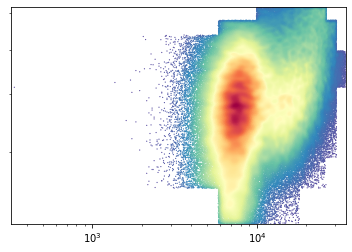

In [283]:
s_g1 = fc.gate.density2d(test.as_dataframe(source="raw")[['FSC-H', 'SSC-H']].values, gate_fraction=0.5, full_output=True)
print(s_g1.mask.all())
fc.plot.density2d(s_g1.gated_data,
                        mode='scatter')
plt.show()

False


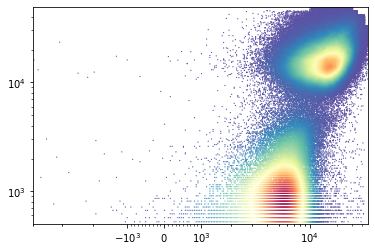

In [271]:
s_g1 = fc.gate.density2d(test.as_dataframe(source="xform")[['FSC-H', 'SSC-H']].values, gate_fraction=0.95, full_output=True)
print(s_g1.mask.all())
fc.plot.density2d(s_g1.gated_data,
                        mode='scatter')
plt.show()

In [346]:
# test_df = test.as_dataframe(source="raw")
# scaler = MinMaxScaler()
# test_df[['FSC-A', 'SSC-A', 'SSC-B-A']] = scaler.fit_transform(test_df[['FSC-A', 'SSC-A', 'SSC-B-A']])
greater_than_min = (test_df[['FSC-A', 'SSC-A', 'SSC-B-A']] > (test_df[['FSC-A', 'SSC-A', 'SSC-B-A']].mean() - test_df[['FSC-A', 'SSC-A', 'SSC-B-A']].std() * 1.5)).values.all(axis=1)
less_than_max = (test_df[['FSC-A', 'SSC-A', 'SSC-B-A']] < (test_df[['FSC-A', 'SSC-A', 'SSC-B-A']].mean() + test_df[['FSC-A', 'SSC-A', 'SSC-B-A']].std() * 1.5)).values.all(axis=1)

np.array([greater_than_min, less_than_max]).all(axis=0)

array([ True,  True,  True, ...,  True,  True,  True])

In [148]:
print(df.columns.get_level_values(0))
df.columns = df.columns.get_level_values(0)
to_select = ["-A" in col for col in df.columns]

to_select[0] = True
df_select = df.loc[:, to_select]
df_select['fixed'] = True
df_select.reset_index(drop=True, inplace=True)
# df.drop("index",axis=1,inplace=True)
df_select.values

Index(['UV1-A', 'UV2-A', 'UV3-A', 'UV4-A', 'UV5-A', 'UV6-A', 'UV7-A', 'UV8-A',
       'UV9-A', 'UV10-A', 'UV11-A', 'UV12-A', 'UV13-A', 'UV14-A', 'UV15-A',
       'UV16-A', 'SSC-A', 'V1-A', 'V2-A', 'V3-A', 'V4-A', 'V5-A', 'V6-A',
       'V7-A', 'V8-A', 'V9-A', 'V10-A', 'V11-A', 'V12-A', 'V13-A', 'V14-A',
       'V15-A', 'V16-A', 'FSC-A', 'SSC-B-A', 'B1-A', 'B2-A', 'B3-A', 'B4-A',
       'B5-A', 'B6-A', 'B7-A', 'B8-A', 'B9-A', 'B10-A', 'B11-A', 'B12-A',
       'B13-A', 'B14-A', 'YG1-A', 'YG2-A', 'YG3-A', 'YG4-A', 'YG5-A', 'YG6-A',
       'YG7-A', 'YG8-A', 'YG9-A', 'YG10-A', 'R1-A', 'R2-A', 'R3-A', 'R4-A',
       'R5-A', 'R6-A', 'R7-A', 'R8-A', 'strain', 'fixed', 'dilution',
       'light_exp'],
      dtype='object', name='pnn')


/tmp/ipykernel_83551/1028801468.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['fixed'] = True


array([[-0.0735066804936676, 0.35675042791370065, -0.03932611264930608,
        ..., 0.5749212251222804, 0.5201491382502402, True],
       [0.3920623135395697, -0.03617378124476439, -0.14020916996416288,
        ..., 0.5797394964500261, 0.5596647313716516, True],
       [0.03962985966083046, 0.4068964097238054, -0.1613455826954463,
        ..., -0.07325642064454685, 0.40251426427317966, True],
       ...,
       [0.3651167987234976, 0.26703681374296917, -0.0631848715479158,
        ..., 0.40541023129336323, -0.0757653715959406, True],
       [0.3651167987234976, 0.35399952810135166, 0.34968594598725145,
        ..., 0.525096802782412, 0.42978855449098063, True],
       [0.35058210531978146, 0.37846808439196533, 0.3969216005542904,
        ..., 0.5896740336520798, 0.5119655536195964, True]], dtype=object)

In [47]:
print(y_train)

151055    1
269479    1
129146    1
259902    4
133535    0
         ..
69646     4
488636    2
489985    2
15363     2
477602    0
Name: strain, Length: 940485, dtype: int64


In [59]:
from ivis import Ivis

# embedder = UMAP(n_components=2, n_neighbors=100)
# embedder.fit(df)
# print(y_train)

# ivis_embedder = Ivis(n_epochs_without_progress=5)
# ivis_embedder.fit(x_train)
ivis_embedding = ivis_embedder.transform(x_train)

7348/7348 [==============================] - 6s 730us/step


In [70]:
ivis_embedding

array([[-12.615425  ,   0.7372441 ],
       [ -9.287775  ,  -1.4827724 ],
       [  2.1869824 ,   2.747534  ],
       ...,
       [-12.816337  ,  -6.194436  ],
       [  0.13998838,   1.4032309 ],
       [  0.15816058,  -1.1295582 ]], dtype=float32)

[1 1 1 ... 2 2 0]


/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


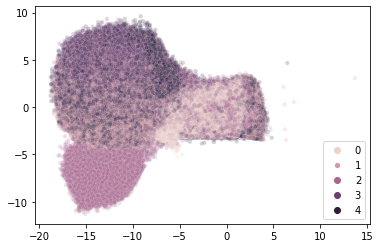

In [72]:
# umap.plot.points(embedder, labels = df_labels.values[:, 0], background='black')
# plt.show()
import seaborn as sns
print(y_train.values)
sns.scatterplot(ivis_embedding[:, 0], ivis_embedding[:, 1], y_train.values, size=1, alpha=0.2)
plt.show()

In [56]:
print(set(df_labels.values[:, 0]))
print(glob.glob(main_dir + "reference_cultures/Pro_and_syn/fixed/*cus*fcs")[0:5])

from ivis import Ivis
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

tf.config.optimizer.set_jit(
    False
)

iris = datasets.load_iris()

X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target)
X = iris.data

# Scale the data to [0, 1]
X_scaled = MinMaxScaler().fit_transform(X_train)

# Set ivis parameters
model = Ivis(embedding_dims=2, k=15, batch_size=10)

# Generate embeddings
embeddings = model.fit_transform(X_scaled, Y_train)

{0, 1, 2, 3, 4}
['/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_5_Prochlorococcus_SS120.fcs', '/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_15_Synechococcus_BB2P1.fcs', '/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_15_Synechococcus_BBP2.fcs', '/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_15_Prochlorococcus_CC9605.fcs', '/home/n10853499/01-projects/00-allison_microscope/reference_cultures/Pro_and_syn/fixed/PFA_15_Synechococcus_IN16_44.fcs']
Building KNN index


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 100677.68it/s]


Extracting KNN neighbours


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 1118.04it/s]


Training neural network
Epoch 1/1000


2022-07-11 10:53:45.512858: W tensorflow/core/framework/op_kernel.cc:1733] UNKNOWN: JIT compilation failed.


UnknownError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/Relu' defined at (most recent call last):
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_16711/3527217787.py", line 24, in <cell line: 24>
      embeddings = model.fit_transform(X_scaled, Y_train)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ivis/ivis.py", line 368, in fit_transform
      self.fit(X, Y, shuffle_mode)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ivis/ivis.py", line 346, in fit
      self._fit(X, Y, shuffle_mode)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ivis/ivis.py", line 318, in _fit
      hist = self.model_.fit(
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/n10853499/.conda/envs/tf/lib/python3.10/site-packages/ivis/nn/losses.py", line 240, in new_loss_function
      y_true_pos = tf.nn.relu(y_true)
Node: 'sparse_categorical_crossentropy/Relu'
JIT compilation failed.
	 [[{{node sparse_categorical_crossentropy/Relu}}]] [Op:__inference_train_function_968083]

In [54]:
print(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     